In [1]:
import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity_1Area import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering, ranktwo_3areas

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np

import torch


size = 300
noise_std = 1e-2
alpha = .1
lr = 1e-3

input_size = 3
output_size = 1

# load a full-rank RNN
net1 = FullRankRNN(3, size, 1, noise_std, alpha)
net1.load_state_dict(torch.load(f'../models/3areas{size}.pt', map_location='cpu'))


# with torch.no_grad():
#     net1.wi.copy_(net.w_in_eff)
#     net1.wo.copy_(net.w_out_eff)
#     net1.wrec.copy_(net.w_rec_eff)


x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net1, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.212, acc=1.000


In [2]:
attributes = net1.__dict__
attributes.keys()

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'input_size', 'hidden_size', 'output_size', 'noise_std', 'alpha', 'rho', 'train_wi', 'train_wo', 'train_wrec', 'train_h0', 'train_si', 'train_so', 'non_linearity', 'output_non_linearity', 'wi_full', 'wo_full', 'w_rec_eff', 'w_in_eff', 'w_out_eff'])

In [3]:
# from sklearn.decomposition import PCA
# wrec_mask = net1.wrec_mask.cpu()

# X = wrec_mask.numpy()
# pca = PCA(n_components=10)
# X_proj = pca.fit_transform(X)
# X_recon = pca.inverse_transform(X_proj)
# plt.imshow(X_recon)

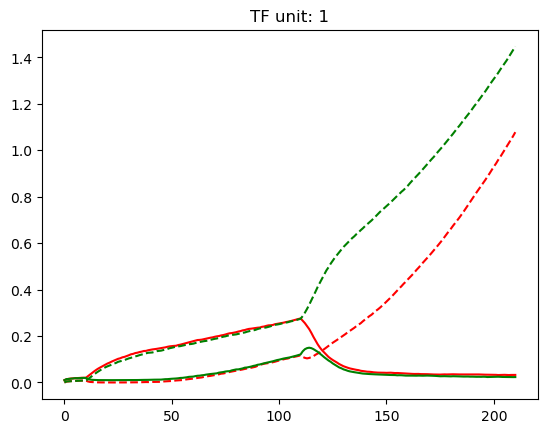

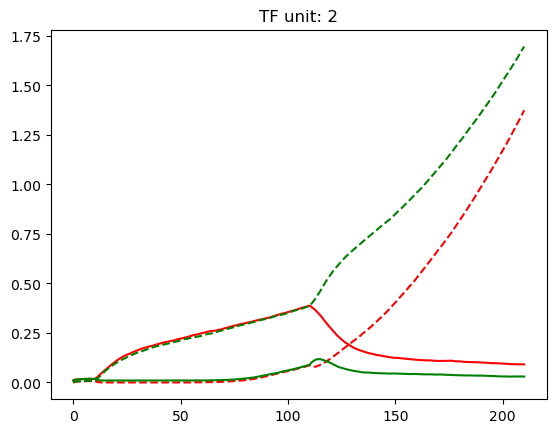

In [4]:
traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1, 0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

for n in range(1,3):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

In [5]:
rank = 2

# reduce the rank of connectivity matrix 
wi_init = net1.w_in_eff.detach()
wo_init = net1.w_out_eff.detach() * size
print(wo_init.std())
wrec = net1.w_rec_eff.detach().cpu().numpy()

# only SVD 1st area 
wrec1 = wrec[:100,:100]
u, s, v = np.linalg.svd(wrec1)
n_init = torch.from_numpy(s[:rank] * u[:, :rank]).to(device=net1.w_rec_eff.device)
m_init = torch.from_numpy(v[:rank, :].transpose()).to(device=net1.w_rec_eff.device)
print(m_init.std())
print(n_init.std())

print(m_init.shape)
print(n_init.shape)


# other areas still full rank
# w_rec_eff = net1.w_rec_eff
# w_rec_eff[:100,:100] = 0


tensor(27.9594)
tensor(0.0861)
tensor(0.3980)
torch.Size([100, 2])
torch.Size([100, 2])


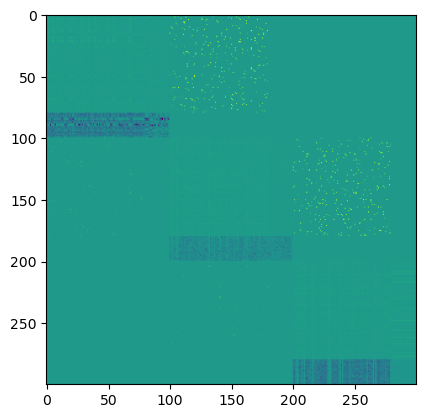

In [6]:
plt.imshow(net1.w_rec_eff)


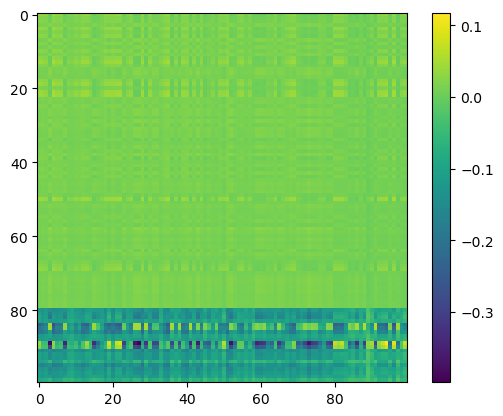

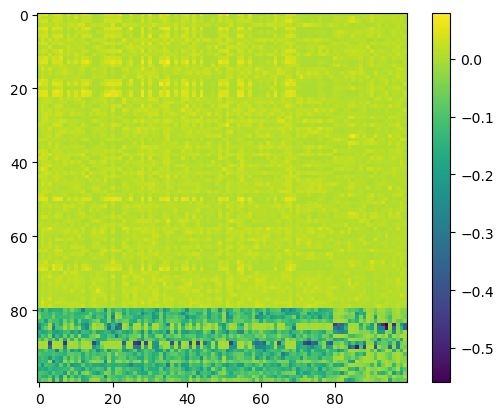

In [7]:
plt.imshow(n_init.matmul(m_init.t()))
plt.colorbar()
plt.show()
plt.imshow(wrec1)
plt.colorbar()

In [8]:

# w_rec_eff = net1.w_rec_eff


# w_rec_eff.to('cuda:0')

net1.w_rec_eff.shape

torch.Size([300, 300])

In [9]:

x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(10000)


# We see that the rank-1 network 
net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=rank, wi_init=wi_init, wo_init=wo_init, m_init=m_init, n_init=n_init, 
                    w_rec_eff = net1.w_rec_eff, wrec_mask = net1.wrec_mask, wi_mask = net1.wi_mask, wo_mask = net1.wo_mask)

net_lo.non_linearity = torch.relu
net_lo.out_non_linearity = torch.eye


train(net_lo, x_train, y_train, mask_train, n_epochs=20, lr=lr, batch_size=100, keep_best=True, cuda=True, clip_gradient=1, early_stop=0.15)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net_lo)

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')


Training...
initial loss: 0.441
epoch 0:  loss=0.288  (took 16.04 s) *
epoch 1:  loss=0.207  (took 15.88 s) *
epoch 2:  loss=0.195  (took 15.57 s) *
epoch 3:  loss=0.190  (took 15.74 s) *
epoch 4:  loss=0.185  (took 15.80 s) *
epoch 5:  loss=0.180  (took 15.81 s) *
epoch 6:  loss=0.178  (took 15.81 s) *
epoch 7:  loss=0.175  (took 15.69 s) *
epoch 8:  loss=0.172  (took 15.70 s) *
epoch 9:  loss=0.170  (took 15.68 s) *
epoch 10:  loss=0.167  (took 15.70 s) *
epoch 11:  loss=0.165  (took 15.74 s) *
epoch 12:  loss=0.164  (took 15.72 s) *
epoch 13:  loss=0.162  (took 15.70 s) *
epoch 14:  loss=0.161  (took 15.65 s) *
epoch 15:  loss=0.159  (took 15.66 s) *
epoch 16:  loss=0.158  (took 15.64 s) *
epoch 17:  loss=0.156  (took 15.69 s) *
epoch 18:  loss=0.155  (took 15.71 s) *
epoch 19:  loss=0.154  (took 16.08 s) *
loss=0.153, acc=1.000


device(type='cpu')

In [10]:
# save the model
# torch.save(net_lo.state_dict(), f'../models/3areasLowRankArea1_{rank}_{size}.pt')


In [1]:


# import sys
# sys.path.append('../')

# from low_rank_rnns.modules_connectivity_1Area import *
# from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering, ranktwo_3areas

# from matplotlib import pyplot as plt
# # %matplotlib notebook
# import random
# import numpy as np

# import torch


# size = 300
# noise_std = 1e-2
# alpha = .1
# lr = 1e-3

# input_size = 3
# output_size = 1
# rank = 2

# # load a full-rank RNN
# net1 = FullRankRNN(3, size, 1, noise_std, alpha)
# net1.load_state_dict(torch.load(f'../models/3areas{size}.pt', map_location='cpu'))
# x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

# loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net1, x_val, y_val, mask_val)
# print(f'loss={loss:.3f}, acc={acc:.3f}')



# # load a low-rank RNN
# net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=rank, w_rec_eff = net1.w_rec_eff)


# net_lo.load_state_dict(torch.load(f'../models/3areasLowRankArea1_{rank}_{size}.pt', map_location='cpu'))


# # x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

# loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
# print(f'loss={loss:.3f}, acc={acc:.3f}')


loss=0.216, acc=1.000
loss=0.155, acc=1.000


In [2]:
att = net_lo.__dict__
att.keys()


dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'input_size', 'hidden_size', 'output_size', 'noise_std', 'alpha', 'rank', 'train_m', 'train_wi', 'train_wo', 'train_wrec', 'train_h0', 'train_si', 'train_so', 'non_linearity', 'output_non_linearity', 'wrec', 'wi_full', 'wo_full', 'w_rec', 'w_in_eff', 'w_out_eff'])

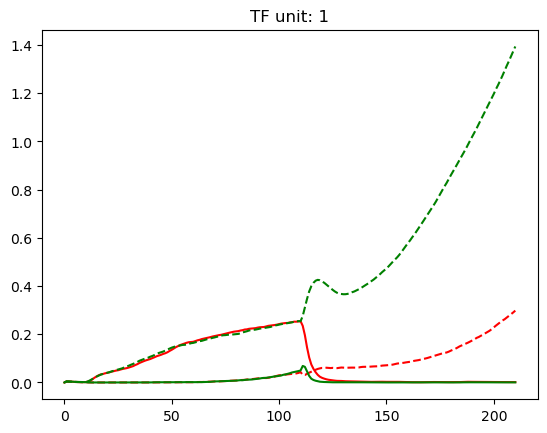

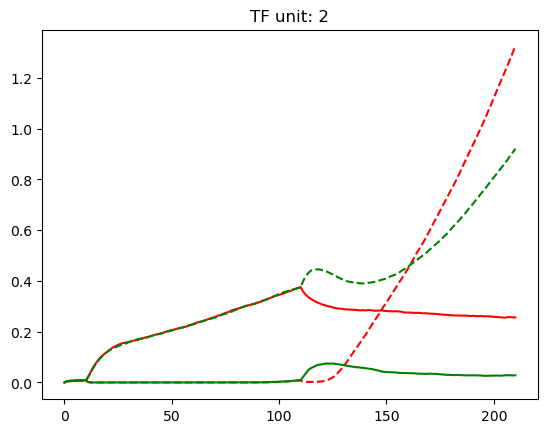

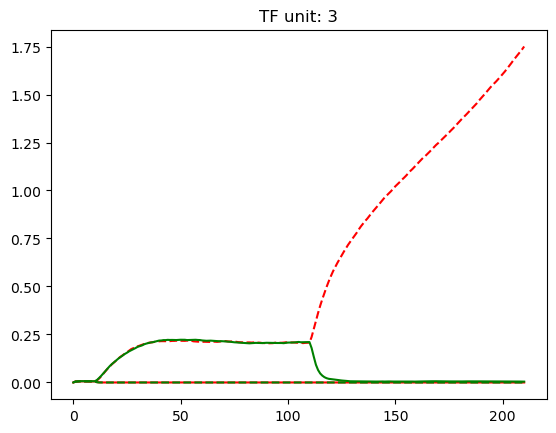

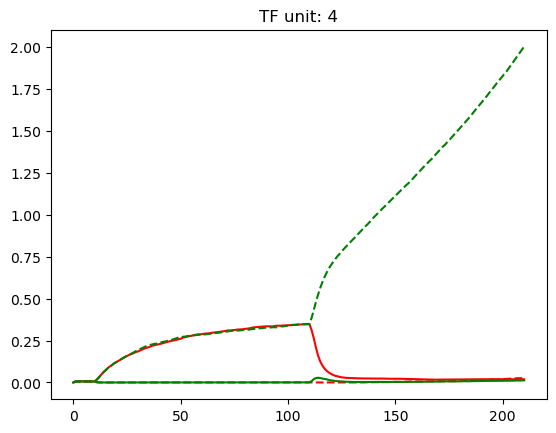

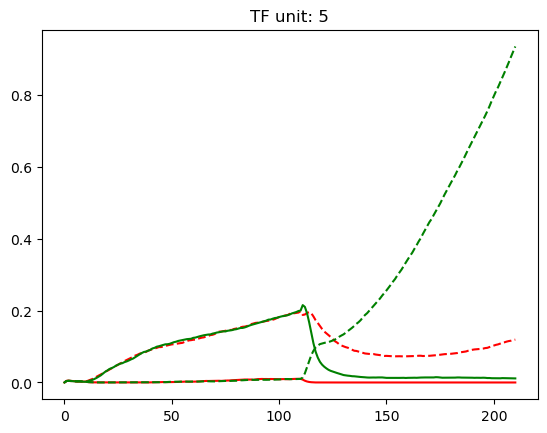

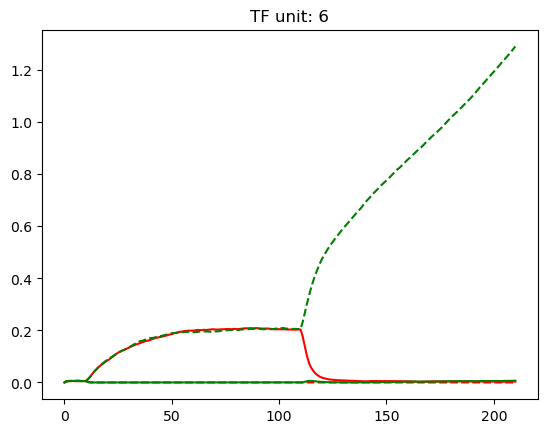

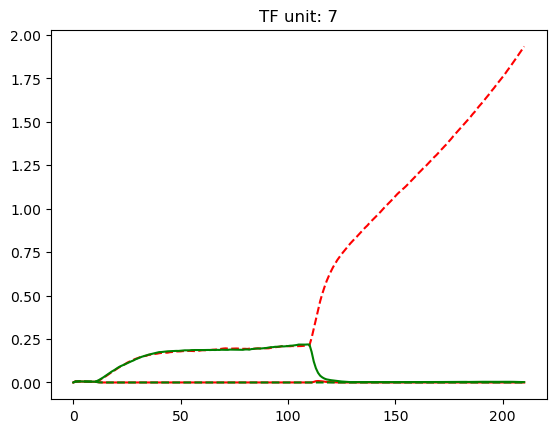

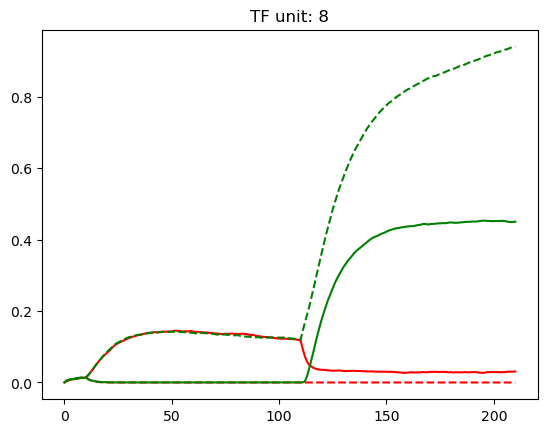

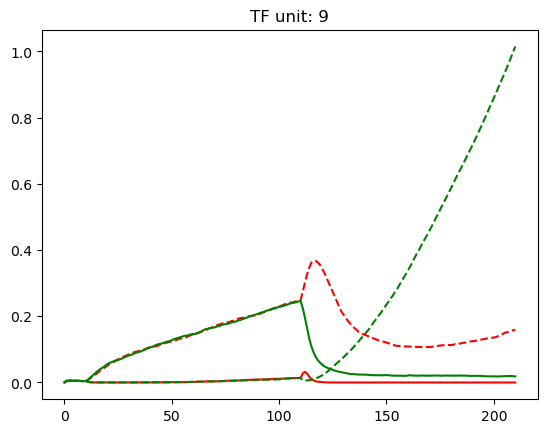

In [4]:
traj = traj.cpu()
decisions = decisions.cpu()
traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1,0)
decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

for n in range(1,10):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

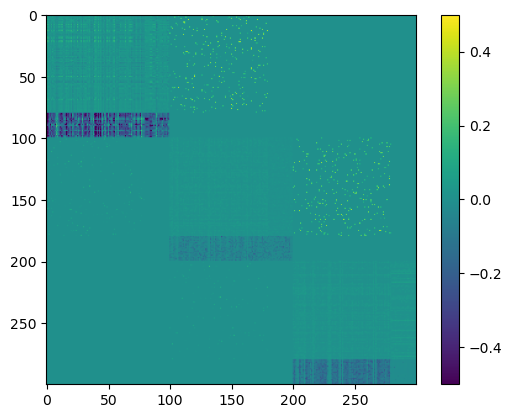

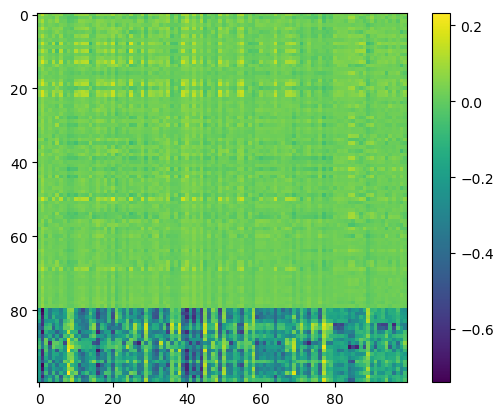

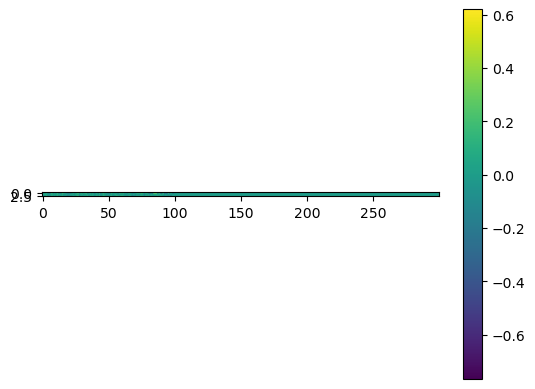

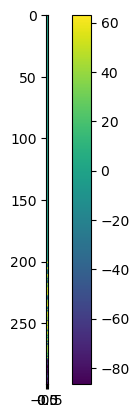

In [14]:
aa = net_lo.w_rec.cpu().detach().numpy()
plt.imshow(aa)
plt.colorbar()
plt.set_cmap('viridis')
plt.clim(-0.5, 0.5)

plt.show()

wrec = (net_lo.n.cpu()).matmul(net_lo.m.t().cpu())
wi = net_lo.wi.cpu()
wo = net_lo.wo.cpu()

a = wrec.detach().numpy()
plt.imshow(a)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

b = wi.detach().numpy()
plt.imshow(b)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

c = wo.detach().numpy()
plt.imshow(c)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()





In [5]:
net_lo.cpu().svd_reparametrization()

# n: low-rank Wrec connectivity vector n
n = net_lo.n.cpu().detach().numpy()
# n3 = net_lo.n[:, 2].detach().numpy()
# n4 = net_lo.n[:, 3].detach().numpy()


# m: low-rank Wrec connectivity vector m
m = net_lo.m.cpu().detach().numpy()
# m3 = net_lo.m[:, 2].detach().numpy()
# m4 = net_lo.m[:, 3].detach().numpy()




In [6]:
trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

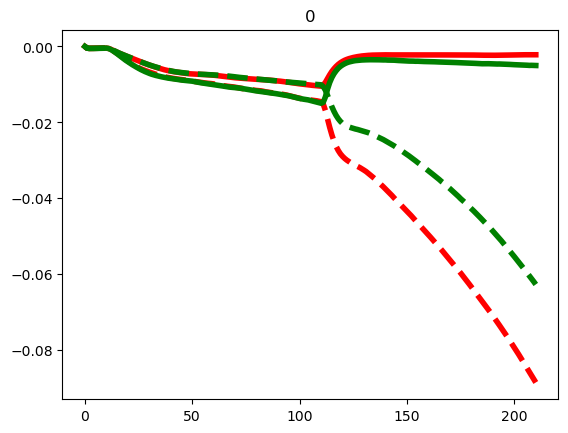

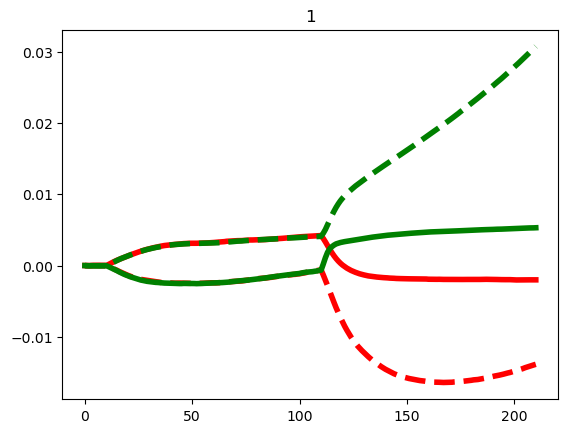

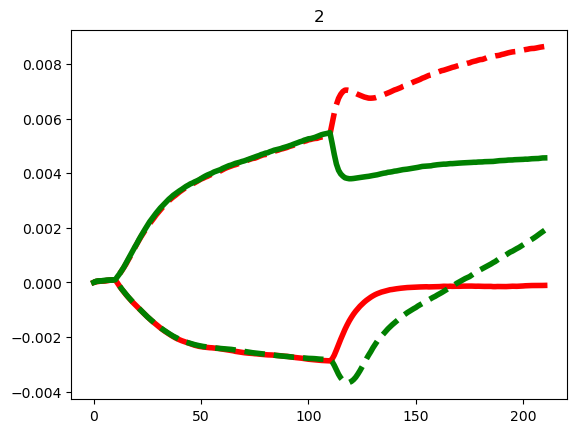

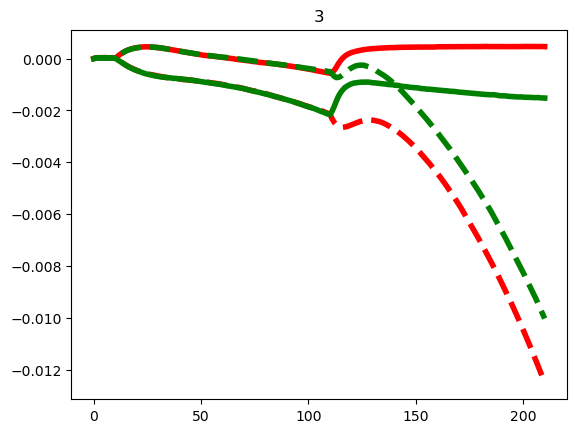

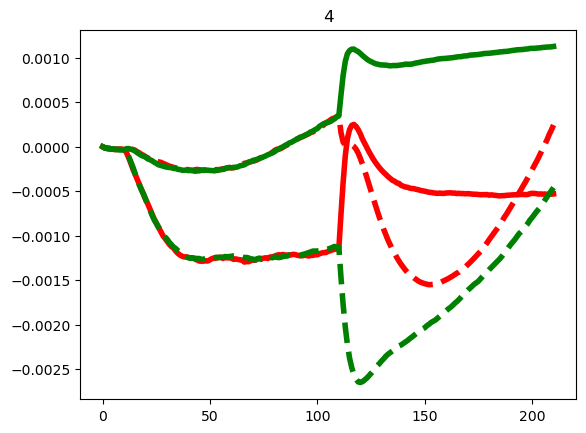

In [7]:
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']


def projLow(trajLow, m, plotTraj): 
    # project low rank rnn traj on m vector
    kap = np.zeros((trajLow.shape[0], trajLow.shape[1], m.shape[1]))
    for ii in range(m.shape[1]):
        kap[:,:,ii] = trajLow @ m[:,ii] / size
    
    
    colors = ['red', 'red', 'green', 'green']
    lineStyle = ['-', '--', '-', '--']

    if plotTraj:
        for jj in range(kap.shape[2]):
            plt.figure()
            for i in range(4):
                plt.plot(kap[i,:,jj], c=colors[i], lw=4, ls=lineStyle[i])
            plt.title(jj)
            plt.show()

    return kap



# area 1 proj 
kap = projLow(trajLow[:,:,:100], m, True)



(844, 100)


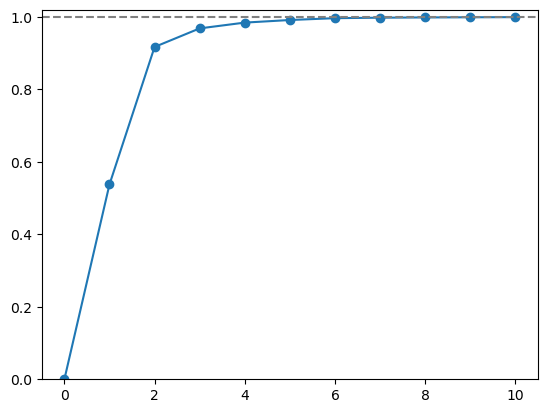

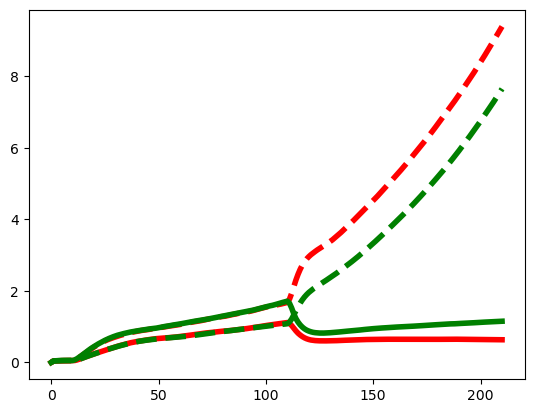

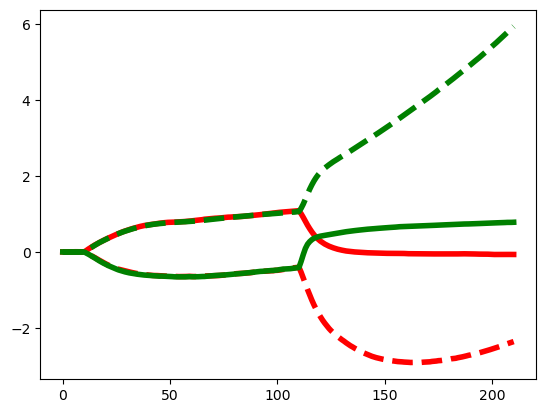

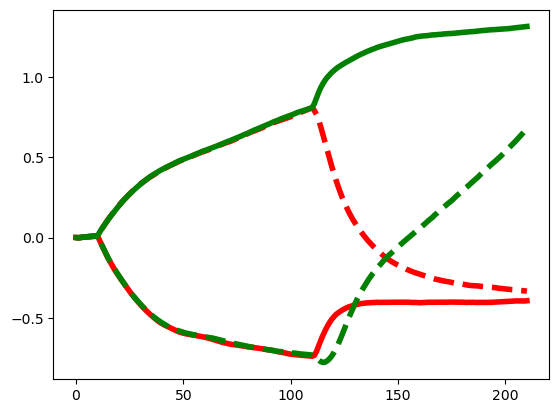

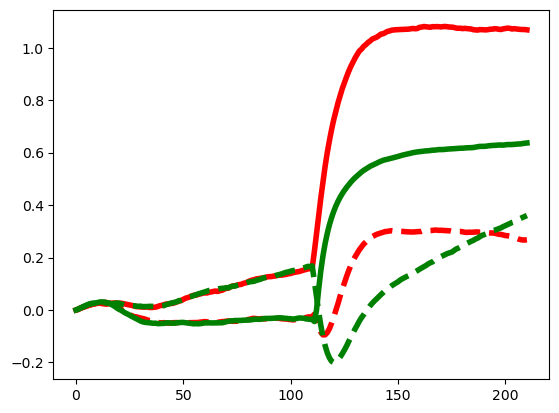

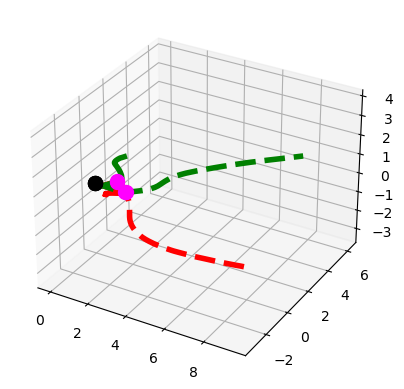

In [10]:
# low rank RNN PCA 

def areaPCA(trajLow):
    TOn = 10
    COn = 100
    
    pca = plot.pca_cumvar(trajLow, n_components=10)
    plt.ylim(0, 1.02)
    plt.axhline(1, ls='--', c='gray')
    plt.show()
    
    labels = ['RL', 'RR', 'GL', 'GR']
    
    ax1 = pca.components_[0]
    ax2 = pca.components_[1]
    ax3 = pca.components_[2]
    ax4 = pca.components_[3]
    
    k1 = trajLow @ ax1
    k2 = trajLow @ ax2
    k3 = trajLow @ ax3
    k4 = trajLow @ ax4
    
    plt.figure()
    for i in range(4):
    #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
        plt.plot(k1[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
    #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
        plt.plot(k2[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
        plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
        plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
    plt.show()
    
    # 3D pca plot
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(4):
        plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
        ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
                marker='.', s=400)
        ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
                marker='.', s=400)
    ax.axis('equal')

# area 1:
areaPCA(trajLow[:,:,:100])
# area 2:
# areaPCA(trajLow[:,:,100:200])
# area 3:
# areaPCA(trajLow[:,:,200:])

## vector fields

In [45]:
# kap = projLow(trajLow[:,:,:100], m[:100,:], False)
kap = projLow(trajLow[:,:,:100], m, False)

kap.shape

(4, 211, 15)

In [46]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from scipy.optimize import root
from low_rank_rnns.helpers import phi_prime
from low_rank_rnns.plotting import adjust_plot

def plot_field(net, vec1=None, vec2=None, xmin=-3, xmax=3, ymin=-3, ymax=3, input=None, res=50,
               ax=None, add_fixed_points=False, fixed_points_trials=10, fp_save=None, fp_load=None, nojac=False,
               orth=False, sizes=1.):
    """
    Plot 2d flow field and eventually fixed points for a rank 2 network. Can plot the affine flow field in presence of a
    constant input with argument input.
    :param net: a LowRankRNN
    :param vec1: None or a numpy array of shape (hidden_size). If None, will be taken as vector m1 of the network
    :param vec2: same with m2
    :param xmin: float
    :param xmax: float
    :param ymin: float
    :param ymax: float
    :param input: None or torch tensor of shape (n_inputs), provides constant input for plotting affine flow field
    :param res: int, grid resolution
    :param ax: None or matplotlib axes
    :param add_fixed_points: bool
    :param fixed_points_trials: int, number of simulations to launch to find fixed points
    :param fp_save: None or filename, to save found fixed points instead of plotting them
    :param fp_load: None or filename, to load fixed points instead of recomputing them
    :param nojac: bool, if True, use root solver without jacobian matrix
    :param orth: bool, if True, start by orthogonalizing (vec1, vec2)
    :param sizes: float, general scaling factor for arrows
    :return: axes, mappable (for colorbar)
    """
    if ax is None:
        fig, ax = plt.subplots()
    adjust_plot(ax, xmin, xmax, ymin, ymax)
    if vec1 is None:
        vec1 = net.m[:, 0].squeeze().detach().numpy()
    if vec2 is None:
        vec2 = net.m[:, 1].squeeze().detach().numpy()
    if add_fixed_points:
        n1 = net.n[:, 0].squeeze().detach().numpy()
        n2 = net.n[:, 1].squeeze().detach().numpy()
    m = net.m.detach().numpy()
    n = net.n.detach().numpy()

    # Plotting constants
    nx, ny = res, res
    marker_size = 50 * sizes

    # Orthogonalization of the basis vec1, vec2, I
    if orth:
        vec2 = vec2 - (vec2 @ vec1) * vec1 / (vec1 @ vec1)
    if input is not None:
        I = (input @ net.wi_full[:,:100]).detach().numpy()
        I_orth = I - (I @ vec1) * vec1 / (vec1 @ vec1) - (I @ vec2) * vec2 / (vec2 @ vec2)
    else:
        I = np.zeros(net.hidden_size/3)
        I_orth = np.zeros(net.hidden_size/3)

    # rescaling factors (for transformation euclidean space / overlap space)
    # here, if one wants x s.t. overlap(x, vec1) = alpha, x should be r1 * alpha * vec1
    # with the overlap being defined as overlap(u, v) = u.dot(v) / sqrt(hidden_size)
    r1 = net.hidden_size/3 / (vec1 @ vec1)
    r2 = net.hidden_size/3 / (vec2 @ vec2)

    # Defining the grid
    xs_grid = np.linspace(xmin, xmax, nx + 1)
    ys_grid = np.linspace(ymin, ymax, ny + 1)
    xs = (xs_grid[1:] + xs_grid[:-1]) / 2
    ys = (ys_grid[1:] + ys_grid[:-1]) / 2
    field = np.zeros((nx, ny, 2))
    X, Y = np.meshgrid(xs, ys)

    # Recurrent function of dx/dt = F(x, I)
    def F(x, I):
        return -x + m @ (n.T @ np.maximum(x,0)) / (net.hidden_size/3) + I

    # Compute flow in each point of the grid
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            h = r1 * x * vec1 + r2 * y * vec2 + I_orth
            delta = F(h, I)
            field[j, i, 0] = delta @ vec1
            field[j, i, 1] = delta @ vec2
    ax.streamplot(xs, ys, field[:, :, 0], field[:, :, 1], color='white', density=0.5, arrowsize=sizes,
                  linewidth=sizes*.8)
    norm_field = np.sqrt(field[:, :, 0] ** 2 + field[:, :, 1] ** 2)
    mappable = ax.pcolor(X, Y, norm_field)

   
    return ax, mappable


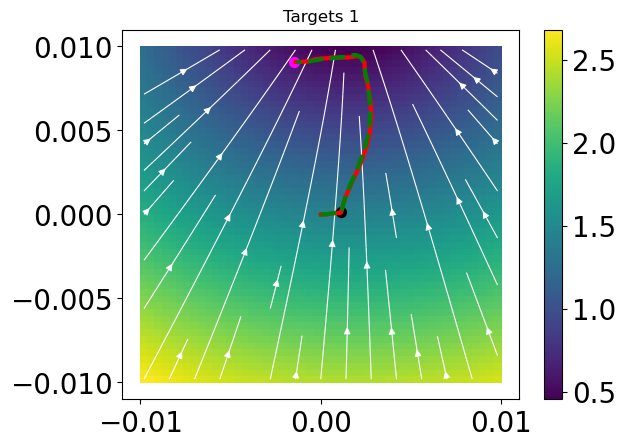

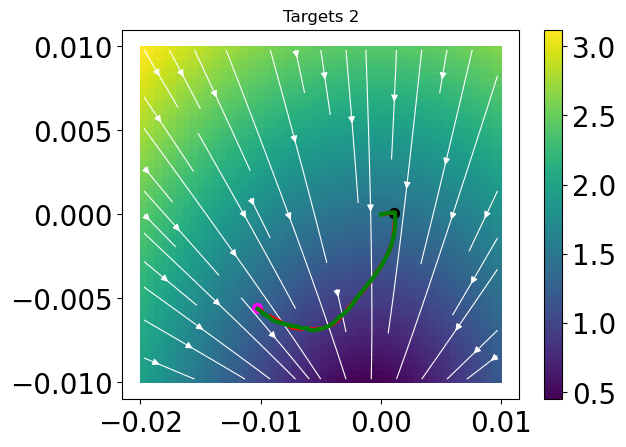

In [48]:
TOn = 10
COn = 100

# only target epoch
dim1 = 0
dim2 = 1

kap1T = kap[:,:COn, dim1]
kap2T = kap[:,:COn, dim2]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = plot_field(net_lo, m[:, dim1], m[:,dim2], -0.01, 0.01, -0.01, 0.01, input=torch.tensor([0.,1, -1]))
mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap1T[0], kap2T[0], c=colors[0], lw=3, ls=lineStyle[0])
plt.plot(kap1T[3], kap2T[3], c=colors[3], lw=3, ls=lineStyle[3])
plt.scatter(kap[0, TOn,dim1], kap[0, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[0, COn, dim1], kap[0, COn, dim2], c= 'magenta',
    marker='.', s=200) 
        
plt.title('Targets 1')        
# # plt.savefig('TFT1.pdf', bbox_inches='tight')
        
plt.show()

# target 1 epoch 
[ax, mappable] = plot_field(net_lo, m[:, dim1], m[:,dim2],  -0.02, 0.01, -0.01, 0.01, input=torch.tensor([0.,-1, 1]))
mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap1T[1], kap2T[1], c=colors[0], lw=3, ls=lineStyle[1])
plt.plot(kap1T[2], kap2T[2], c=colors[3], lw=3, ls=lineStyle[2])
plt.scatter(kap[1, TOn, dim1], kap[1, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[1, COn, dim1], kap[1, COn, dim2], c= 'magenta',
    marker='.', s=200) 
        
plt.title('Targets 2')        
# # plt.savefig('TFT2.pdf', bbox_inches='tight')
        
plt.show()


In [54]:
kap1T.shape

(4, 100)

In [55]:
kap.shape

(4, 211, 5)

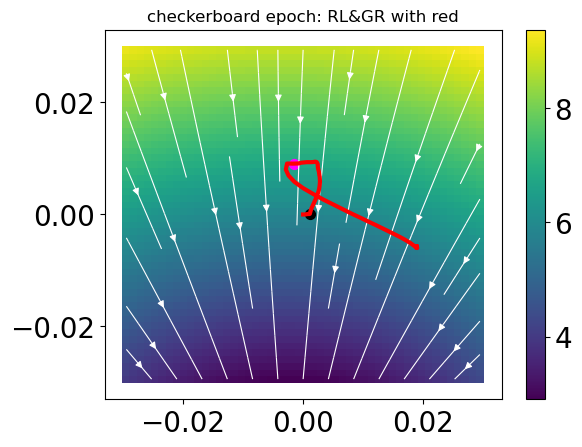

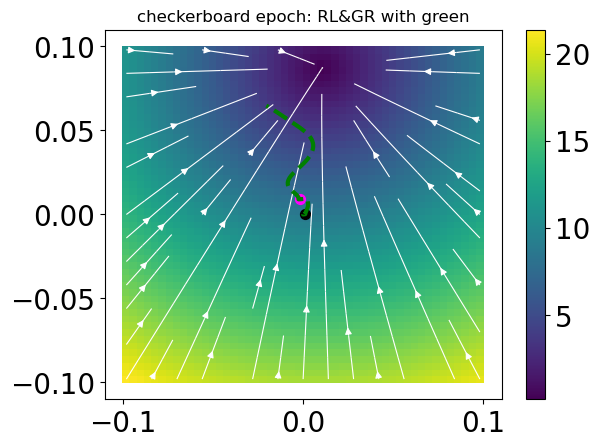

In [51]:

# checkerboard epoch
kap1C = kap[:,COn:, dim1]
kap3C = kap[:,COn:, dim2]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = plot_field(net_lo, m[:, dim1], m[:,dim2], -0.03, 0.03, -0.03, 0.03, input=torch.tensor([0.9,1, -1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap[0,:,dim1], kap[0,:,dim2], c=colors[0], lw=3, ls=lineStyle[0])
plt.scatter(kap[0, TOn, dim1], kap[0, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[0, COn, dim1], kap[0, COn, dim2], c= 'magenta',
    marker='.', s=200) 

plt.title('checkerboard epoch: RL&GR with red')        
# plt.savefig('TFT1R.pdf', bbox_inches='tight')
        
plt.show()






# checkerboard epoch

[ax, mappable] = plot_field(net_lo, m[:, dim1], m[:,dim2], -0.1, 0.1, -0.1, 0.1, input=torch.tensor([-0.9,1, -1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap[3,:,dim1], kap[3,:,dim2], c=colors[3], lw=3, ls=lineStyle[3])
plt.scatter(kap[3, TOn, dim1], kap[3, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[3, COn, dim1], kap[3, COn, dim2], c= 'magenta',
    marker='.', s=200) 


plt.title('checkerboard epoch: RL&GR with green')        
# plt.savefig('TFT1G.pdf', bbox_inches='tight')
        
plt.show()



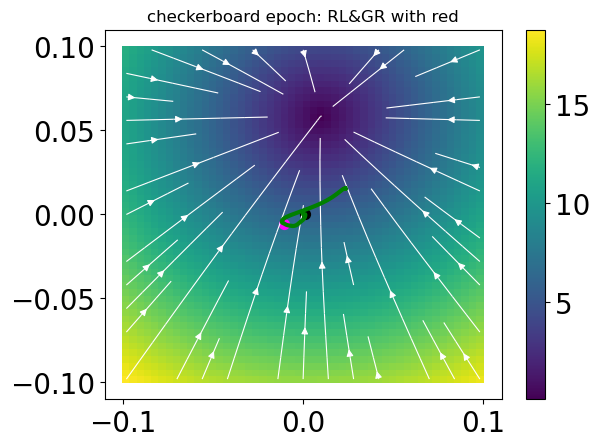

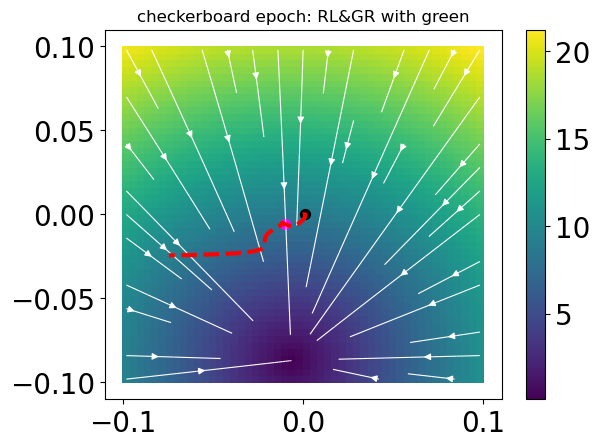

In [52]:
# checkerboard epoch
kap1C = kap[:,COn:, dim1]
kap3C = kap[:,COn:, dim2]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = plot_field(net_lo, m[:, dim1], m[:,dim2], -0.1, 0.1, -0.1, 0.1, input=torch.tensor([-0.9,-1, 1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap[2,:,dim1], kap[2,:,dim2], c=colors[2], lw=3, ls=lineStyle[2])
plt.scatter(kap[2, TOn, dim1], kap[2, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[2, COn, dim1], kap[2, COn, dim2], c= 'magenta',
    marker='.', s=200) 

plt.title('checkerboard epoch: RL&GR with red')        
# plt.savefig('TFT1R.pdf', bbox_inches='tight')
        
plt.show()






# checkerboard epoch

[ax, mappable] = plot_field(net_lo, m[:, dim1], m[:,dim2], -0.1, 0.1, -0.1, 0.1, input=torch.tensor([0.9,-1, 1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap[1,:,dim1], kap[1,:,dim2], c=colors[1], lw=3, ls=lineStyle[1])
plt.scatter(kap[1, TOn, dim1], kap[1, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[1, COn, dim1], kap[1, COn, dim2], c= 'magenta',
    marker='.', s=200) 


plt.title('checkerboard epoch: RL&GR with green')        
# plt.savefig('TFT1G.pdf', bbox_inches='tight')
        
plt.show()
